In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
plt.style.use(['ggplot','seaborn-talk'])

# We will use the odeint routine
from scipy.integrate import odeint
# With a wrapper to facilitate 2d arrays
from odeintw import odeintw

In [2]:
# Master Equations
@jit(nopython=True)
def J(x, t, alpha_p,alpha_m,phi_p,phi_m,gamma_p,gamma_m,beta_p,beta_m):
    """
    Time derivative of the occupation numbers.
        * x is the state distribution (array like)
        * t is time (scalar)
        * alpha is the prey birth rate
        * gamma is the predator death rate
        * beta is the predation rate
        * NB: We use logistic growth for preys to limit the # of states
        * K will be the carrying capacity
    """
    
    K = x.shape[0]

    dx = 0*x
    for h, f in np.ndindex(x.shape):
        
        if (h == 0) & (f == 0): # all off p[0,0]
            dx[h,f] -= x[h,f]*alpha_p
            dx[h,f] += x[h,f+1]*alpha_m
            dx[h,f] -= x[h,f]*phi_p
            dx[h,f] += x[h+1,f]*phi_m
            #dx[h,f,t] -= x[h,f,t]*L
        
        if (h == 1) & (f == 0): # hp on p[1,0]
            dx[h,f] -= x[h,f]*gamma_p
            dx[h,f] += x[h,f+1]*gamma_m
            dx[h,f] -= x[h,f]*phi_m
            dx[h,f] += x[h-1,f]*phi_p
        
        if (h == 0) & (f == 1): # f on p[0,1]
            dx[h,f] -= x[h,f]*beta_p
            dx[h,f] += x[h+1,f]*beta_m
            dx[h,f] -= x[h,f]*alpha_m
            dx[h,f] += x[h,f-1]*alpha_p
        
        if (h == 1) & (f == 1): # all on h[1,1] 
            dx[h,f] -= x[h,f]*gamma_m
            dx[h,f] += x[h,f-1]*gamma_p
            dx[h,f] -= x[h,f]*beta_m
            dx[h,f] += x[h-1,f]*beta_p

    return dx

In [94]:
nb_of_states = 2
x = np.zeros((nb_of_states,nb_of_states))
x[1,1] = 1
print(x)

[[0. 0.]
 [0. 1.]]


In [95]:
for h, f in np.ndindex(x.shape):
    print(h,f)

0 0
0 1
1 0
1 1


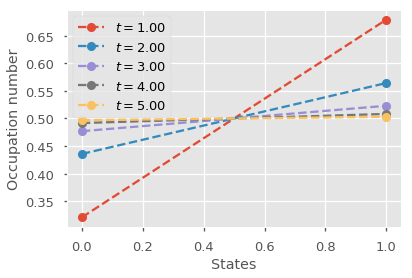

In [232]:
# Time of observations
t_length = 40
t_steps = 40
t_vec = np.linspace(0, t_length, t_steps)

# Initial conditions
nb_of_states = 2
x_0 = np.zeros((nb_of_states,nb_of_states))
x_0[1,1] = 1

# Parameters
alpha_p = .5
alpha_m = .5
phi_p = .5
phi_m = .5
gamma_p = .5
gamma_m = .5
beta_p = .5
beta_m = .5

# parameters staying put
# p[01]
# p[10]
# p[00]
# p[11]



# Integration
G = lambda x, t: J(x, t, alpha_p,alpha_m,phi_p,phi_m,gamma_p,gamma_m,beta_p,beta_m)
x_path = odeintw(G, x_0, t_vec)

# Plot
for t in np.arange(1,6,1):
    plt.plot(range(nb_of_states),np.sum(x_path[t],axis=0), marker="o", ls='--', label=fr"$t = {t_length*t/t_steps:.2f}$")
plt.legend()
plt.ylabel('Occupation number')
plt.xlabel('States')
plt.show()

In [233]:
states = [[0,0],[0,1],[1,0],[1,1]]

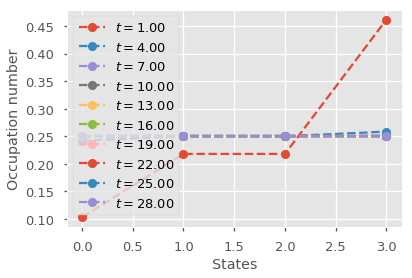

In [234]:
# Plot

for t in np.arange(1,30,3):
    plt.plot(range(4),x_path[t].tolist()[0]+x_path[t].tolist()[1], marker="o", ls='--', label=fr"$t = {t_length*t/t_steps:.2f}$")
plt.legend()
plt.ylabel('Occupation number')
plt.xlabel('States')
plt.show()

## Accounting for Temperature Changes

In [302]:
# Master Equations with Temperature
@jit(nopython=True)
def J2(x, alpha_p, alpha_m, phi_p, phi_m, gamma_p, gamma_m, beta_p, beta_m, L, F, H, omega):
    """
    Time derivative of the occupation numbers.

        * x is the state distribution (array like)
        * alpha - transition b/t p[00] and p[01]
        * phi - transition b/t p[00] and p[01]
        * gamma - transition b/t p[00] and p[01]
        * beta - transition b/t p[00] and p[01]
        * L - loss from no heat
        * F - heating for fossil
        * H - heating for heat pump
        * omega - heating for both 
    """
    K = x.shape[0]

    dx = 0*x
    for h, f, Ti in np.ndindex(x.shape):
        
        #T is external parameter
#         Ta = temp[T]

        if (h == 0) & (f == 0): # all off p[0,0]
            dx[h,f,Ti] -= x[h,f,Ti]*alpha_p
            dx[h,f,Ti] += x[h,f+1,Ti]*alpha_m
            dx[h,f,Ti] -= x[h,f,Ti]*phi_p
            dx[h,f,Ti] += x[h+1,f,Ti]*phi_m
            dx[h,f,Ti] -= x[h,f,Ti]*L
            if Ti<x.shape[2]-1:
                dx[h,f,Ti] += x[h,f,Ti+1]*L
        
        if (h == 1) & (f == 0): # hp on p[1,0]
            dx[h,f,Ti] -= x[h,f,Ti]*gamma_p
            dx[h,f,Ti] += x[h,f+1,Ti]*gamma_m
            dx[h,f,Ti] -= x[h,f,Ti]*phi_m
            dx[h,f,Ti] += x[h-1,f,Ti]*phi_p
            dx[h,f,Ti] -= x[h,f,Ti]*H
            if Ti>0:
                dx[h,f,Ti] += x[h,f,Ti-1]*H
        
        if (h == 0) & (f == 1): # f on p[0,1]
            dx[h,f,Ti] -= x[h,f,Ti]*beta_p
            dx[h,f,Ti] += x[h+1,f,Ti]*beta_m
            dx[h,f,Ti] -= x[h,f,Ti]*alpha_m
            dx[h,f,Ti] += x[h,f-1,Ti]*alpha_p
            dx[h,f,Ti] -= x[h,f,Ti]*F
            if Ti>0:
                dx[h,f,Ti] += x[h,f,Ti-1]*F
        
        if (h == 1) & (f == 1): # all on h[1,1] 
            dx[h,f,Ti] -= x[h,f,Ti]*gamma_m
            dx[h,f,Ti] += x[h,f-1,Ti]*gamma_p
            dx[h,f,Ti] -= x[h,f,Ti]*beta_m
            dx[h,f,Ti] += x[h-1,f,Ti]*beta_p
            dx[h,f,Ti] -= x[h,f,Ti]*omega
            if Ti>0:
                dx[h,f,Ti] += x[h,f,Ti-1]*omega
            

    return dx

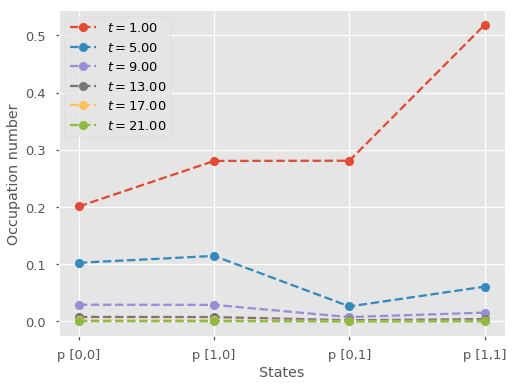

In [392]:
# Time of observations
t_length = 24
t_steps = 24
t_vec = np.linspace(0, t_length, t_steps)

# Initial conditions
nb_of_states = 2
temp_states = 2

x_0 = np.zeros((3,2,temp_states))
x_0[1,1] = 1

# Parameters
alpha_p = .1
alpha_m = .5
phi_p = .5
phi_m = .5
gamma_p = .5
gamma_m = .5
beta_p = .5
beta_m = .5



# Temp Transitions
L = .5
F = .6
H = .3
omega = .9

# Integration: J2(x, alpha_p,alpha_m,phi_p,phi_m,gamma_p,gamma_m,beta_p,beta_m, L,F,H,omega):
G = lambda x, t: J2(x, alpha_p,alpha_m,phi_p,phi_m,gamma_p,gamma_m,beta_p,beta_m,L,F,H,omega)
x_path = odeintw(G, x_0, t_vec)

# Plot
plt.figure(figsize=(8,6))

x1 = [0,1,2,3]

for t in np.arange(1,24,4):
#     plt.plot(range(nb_of_states),np.sum(x_path[t]), marker="o", ls='--', label=fr"$t = {t_length*t/t_steps:.2f}$")
#     plt.plot(range(9),x_path[t].tolist()[0]+x_path[t].tolist()[1], marker="o", ls='--', label=fr"$t = {t_length*t/t_steps:.2f}$")
    plt.plot(x1,np.sum(x_path[t],axis=0)[0].tolist()+np.sum(x_path[t],axis=0)[1].tolist(), marker="o", ls='--', label=fr"$t = {t_length*t/t_steps:.2f}$")
plt.legend()
plt.ylabel('Occupation number')
plt.xlabel('States')
labels = ['p [0,0]', 'p [1,0]', 'p [0,1]','p [1,1]']
plt.xticks(x1, labels)
plt.show()

In [373]:
x_path[t][1,1]

array([0.00010106, 0.00020414])

In [380]:
x_path[2]

array([[[0.11325451, 0.12567029],
        [0.04811098, 0.11194458]],

       [[0.08979086, 0.16290332],
        [0.06407465, 0.15866462]],

       [[0.        , 0.        ],
        [0.        , 0.        ]]])

# Creating Loops

In [397]:
# Master Equations with Temperature
@jit(nopython=True)
def J3(x,alpha_p,alpha_m,phi_p,phi_m,gamma_p,gamma_m,beta_p,beta_m, L,F,H,omega,h00,h11,h01,h10):
    """
    Time derivative of the occupation numbers.

        * x is the state distribution (array like)
        * alpha - transition b/t p[00] and p[01]
        * phi - 
        * gamma
        * beta
        * L - loss from no heat
        * F - heating for fossil
        * H - heating for heat pump
        * omega - heating for both 
    """
    K = x.shape[0]

    dx = 0*x
    for h, f, Ti in np.ndindex(x.shape):

        if (h == 0) & (f == 0): # all off p[0,0]
            dx[h,f,Ti] -= x[h,f,Ti]*alpha_p
            dx[h,f,Ti] += x[h,f+1,Ti]*alpha_m
            dx[h,f,Ti] -= x[h,f,Ti]*phi_p
            dx[h,f,Ti] += x[h+1,f,Ti]*phi_m
            dx[h,f,Ti] -= x[h,f,Ti]*L
            dx[h,f,Ti] += x[h,f,Ti]*h00
            if Ti<x.shape[2]-1:
                dx[h,f,Ti] += x[h,f,Ti+1]*L
        
        if (h == 1) & (f == 0): # hp on p[1,0]
            dx[h,f,Ti] -= x[h,f,Ti]*gamma_p
            dx[h,f,Ti] += x[h,f+1,Ti]*gamma_m
            dx[h,f,Ti] -= x[h,f,Ti]*phi_m
            dx[h,f,Ti] += x[h-1,f,Ti]*phi_p
            dx[h,f,Ti] -= x[h,f,Ti]*H
            dx[h,f,Ti] += x[h,f,Ti]*h10
            if Ti>0:
                dx[h,f,Ti] += x[h,f,Ti-1]*H
        
        if (h == 0) & (f == 1): # f on p[0,1]
            dx[h,f,Ti] -= x[h,f,Ti]*beta_p
            dx[h,f,Ti] += x[h+1,f,Ti]*beta_m
            dx[h,f,Ti] -= x[h,f,Ti]*alpha_m
            dx[h,f,Ti] += x[h,f-1,Ti]*alpha_p
            dx[h,f,Ti] -= x[h,f,Ti]*F
            dx[h,f,Ti] += x[h,f,Ti]*h01
            if Ti>0:
                dx[h,f,Ti] += x[h,f,Ti-1]*F
        
        if (h == 1) & (f == 1): # all on h[1,1] 
            dx[h,f,Ti] -= x[h,f,Ti]*gamma_m
            dx[h,f,Ti] += x[h,f-1,Ti]*gamma_p
            dx[h,f,Ti] -= x[h,f,Ti]*beta_m
            dx[h,f,Ti] += x[h-1,f,Ti]*beta_p
            dx[h,f,Ti] -= x[h,f,Ti]*omega
            dx[h,f,Ti] += x[h,f,Ti]*h11
            if Ti>0:
                dx[h,f,Ti] += x[h,f,Ti-1]*omega

    return dx

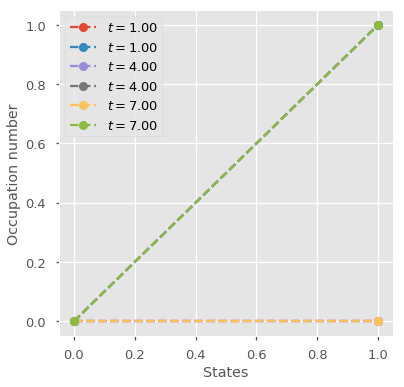

In [417]:
# Time of observations
t_length = 40
t_steps = 40
t_vec = np.linspace(0, t_length, t_steps)

# Initial conditions
nb_of_states = 2
t_states = 3

x_0 = np.zeros((t_states,nb_of_states,nb_of_states))
#x_0[1,1,1] = 1
x_0[2,1,1] = 1

# Parameters
alpha_p = .1
alpha_m = .5
phi_p = .5
phi_m = .5
gamma_p = .5
gamma_m = .5
beta_p = .5
beta_m = .5

# parameters - remain
h00 = .25
h11 = .25
h01 = .25
h10 = .25

# Temp Transitions
L = .5
F = .6
H = .3
omega = .9

# Integration: J2(x, alpha_p,alpha_m,phi_p,phi_m,gamma_p,gamma_m,beta_p,beta_m, L,F,H,omega):
G = lambda x, t: J3(x, alpha_p,alpha_m,phi_p,phi_m,gamma_p,gamma_m,beta_p,beta_m,L,F,H,omega,h00,h11,h01,h10)
x_path = odeintw(G, x_0, t_vec)

# Plot
plt.figure(figsize=(6,6))
for t in np.arange(1,10,3):
    plt.plot(range(nb_of_states),np.sum(x_path[t],axis=0), marker="o", ls='--', label=fr"$t = {t_length*t/t_steps:.2f}$")
#     plt.plot(range(9),x_path[t].tolist()[0]+x_path[t].tolist()[1], marker="o", ls='--', label=fr"$t = {t_length*t/t_steps:.2f}$")
plt.legend()
plt.ylabel('Occupation number')
plt.xlabel('States')
plt.show()

In [418]:
x_path[t]

array([[[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 1.]]])

In [415]:
x_path[2][2,1,1] = 3